# realtime_r0_ts_sir (experimental)


## Using Generalized Additive Models and SIRs definition of reproductive number 

Let us try to estimate the effective reproductive number using Generalized Additive Models and the [SIR definition](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model) of the reproductive number, where

$$\large R_t = \frac{\beta_t}{\gamma}$$

where $\beta_t$ is the *contact rate* or *growth rate* of the epidemic, which can be estimated through GAMs and $\gamma$ is the *recovery rate*, which we set as as $\gamma = 1 / 14$ (14 days to recover).

Most of the code sits on `core.py`, to simplify the notebook.

In [1]:
# importing core 
from core import run_full_model, estimate_gam
from core import run_gam_effective_r_from_counts, run_gam_effective_r_from_empirical
from core import load_data, load_data_us, plot_rt, plot_standings

# basic imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates

# parallel computing
from joblib import Parallel, delayed

# GAMs
from pygam import GammaGAM, PoissonGAM, s, l

# better resolution
%config InlineBackend.figure_format = 'retina'


Bad key "axes.titlelocation" on line 298 in
/Users/guilherme.marmerola/Documents/Repositories/realtime_r0_brazil/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


Área reservada para parâmetros do modelo. Até agora só deixamos aberto `N_JOBS`, para escolher o número de núvleos para o ajuste dos modelos.

In [2]:
### parameters ###

# number of cores to run parallel computing
N_JOBS = -1

# recovery rate
RECOVERY_RATE = 1 / 14

## Reading data

We have fucntions for reading BR and US data.

In [3]:
### reading data ###

# reading BR data
#city_df, state_df = load_data()

# reading for US
state_df = load_data_us()

## Model

Let us try to use the SIR model definition of the reproductive number, and add a twist so it can be the effective reproductive number $R_t$:

$$\large R_t = \frac{\beta_t}{\gamma}$$

where $\beta_t$ is the *contact rate* or *growth rate* for the epidemic, which can be estimated through GAMs and $\gamma$ is the *recovery rate*, which we set as as $\gamma = 1 / 14$ ([14 days to recover](https://github.com/3778/COVID-19#modelos-compartimentados), or that an infected person can pass the virus along).

### Estimate with Raw Data

It is actually easy to calculate $R_t$ using the previous definition with raw data:

In [4]:
# state we want to analyze
STATE_NAME = 'NY'

# getting series for one state
series = (state_df
          .loc[lambda x: x.index.get_level_values(0) == STATE_NAME]
          [['confirmed_new','confirmed_total']])

# we just want to calculate percentage growth here
beta_t = (series['confirmed_new'] / series['confirmed_total'].shift(1))
Rt_raw = beta_t / RECOVERY_RATE

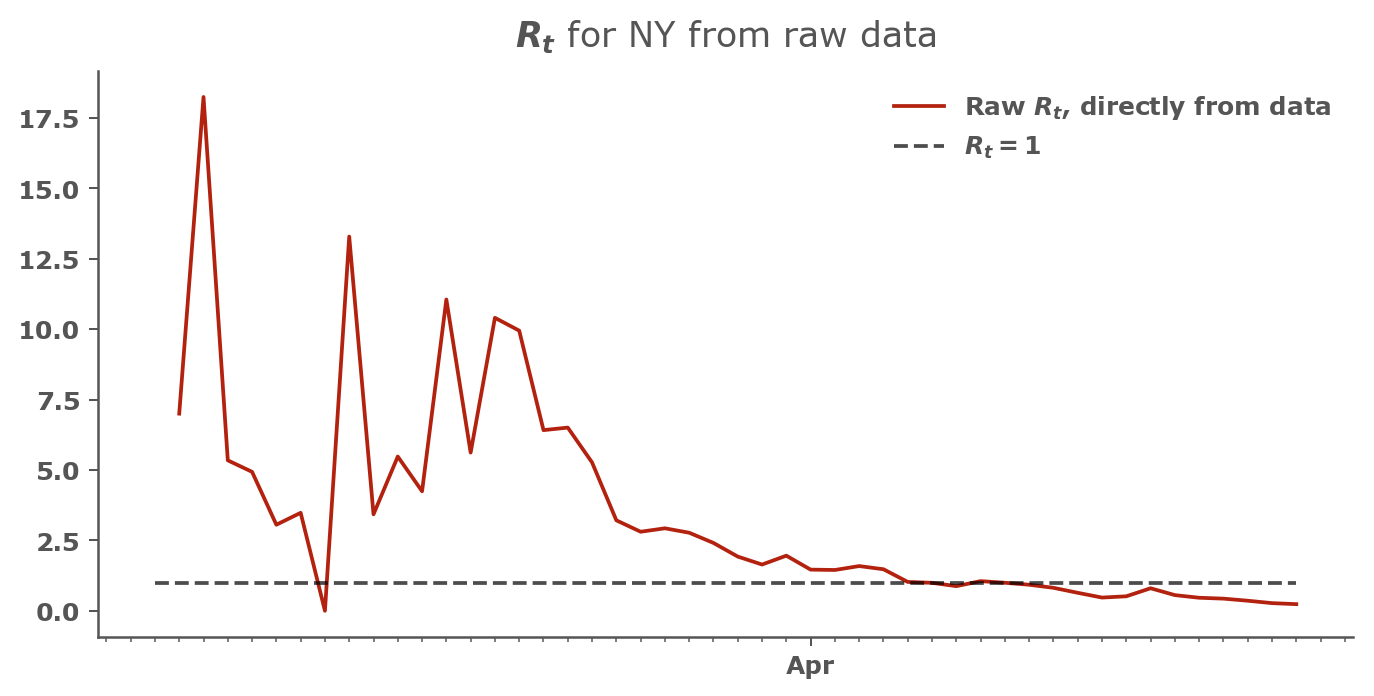

In [5]:
# opening figure
fig, ax = plt.subplots(figsize=(9, 4), dpi=90)

plt.plot(Rt_raw.index.get_level_values(1), Rt_raw, label='Raw $R_t$, directly from data')
plt.plot(Rt_raw.index.get_level_values(1), [1] * Rt_raw.shape[0], 'k--', alpha=0.7, label='$R_t = 1$')

fig.set_facecolor('w') 
ax.set_title(f'$R_t$ for {STATE_NAME} from raw data')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.legend();

But this estimate comes with some shortcomings: 

* There's no smoothing, so estimates vary a lot for small data
* We do not have an uncertainty estimate

To address these shortcomings, we use GAMs.

### Generalized Additive Models

Taken from `pygam` documentation: 

> Generalized Additive Models (GAMs) are smooth semi-parametric models of the form:
>
>$$g(𝔼[𝑦|𝑋])=\beta_0 + f_1(x_1)+f_2(x_2,x_3)+…+𝑓_m(x_n)$$
>
>where $X.T = [x_1, x_2, ..., x_N]$ are independent variables, $y$ is the dependent variable, and $g()$ is the link function that relates our predictor variables to the expected value of the dependent variable.
>
>The feature functions `f_i()` are built using penalized B splines, which allow us to automatically model non-linear relationships without having to manually try out many different transformations on each variable.

This kind of flexibility makes GAMs a good choice for a smoothing function, with added capabilities of modeling the right error distribution (Poisson). We can easily fit the new cases time series with a GAM:

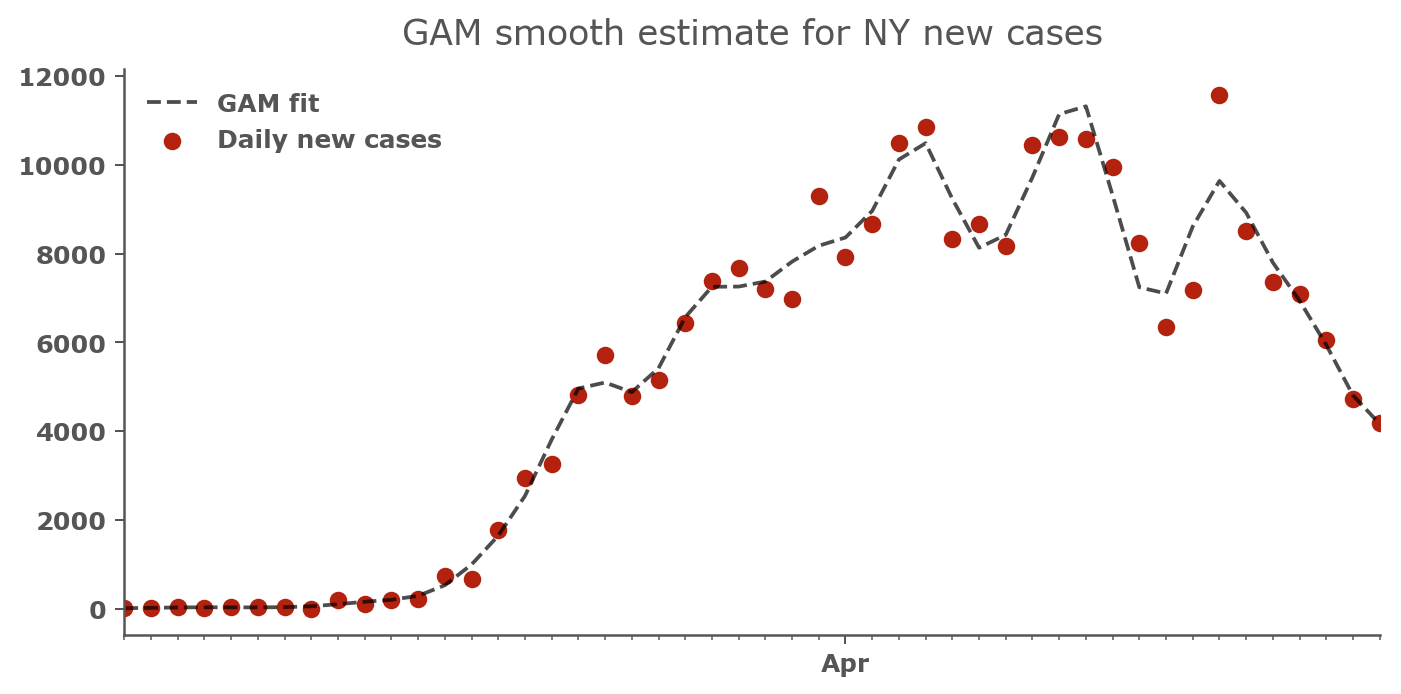

In [15]:
# fitting GAM
X = np.arange(series.shape[0])
y = series['confirmed_new'].values

gam = PoissonGAM(s(0, 25) + l(0))
gam.fit(X, y)

preds = gam.predict(X)

# opening figure
fig, ax = plt.subplots(figsize=(9, 4), dpi=90)

plt.scatter(series.index.get_level_values(1), series['confirmed_new'], label='Daily new cases')
plt.plot(series.index.get_level_values(1), preds, 'k--', alpha=0.7, label='GAM fit')

fig.set_facecolor('w') 
ax.set_title(f'GAM smooth estimate for {STATE_NAME} new cases')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.xlim(series.index.get_level_values(1).min(),
         series.index.get_level_values(1).max())
ax.legend();

We can control the smoothness on the GAM by limiting the number of splines, such as using `s(0, 10)`, instead of `s(0, 25)`. As we're using bootstrap, it should not be a problem to use an expressive model. There's also the `lam` parameter, which works directly on the derivative of the function.

We can add uncertainty to this estimates in a non-parametric way using a [smoothed (bayesian) bootstrap](https://projecteuclid.org/euclid.aos/1176345338) running models with different sample weights drawn from a dirichlet distribution:

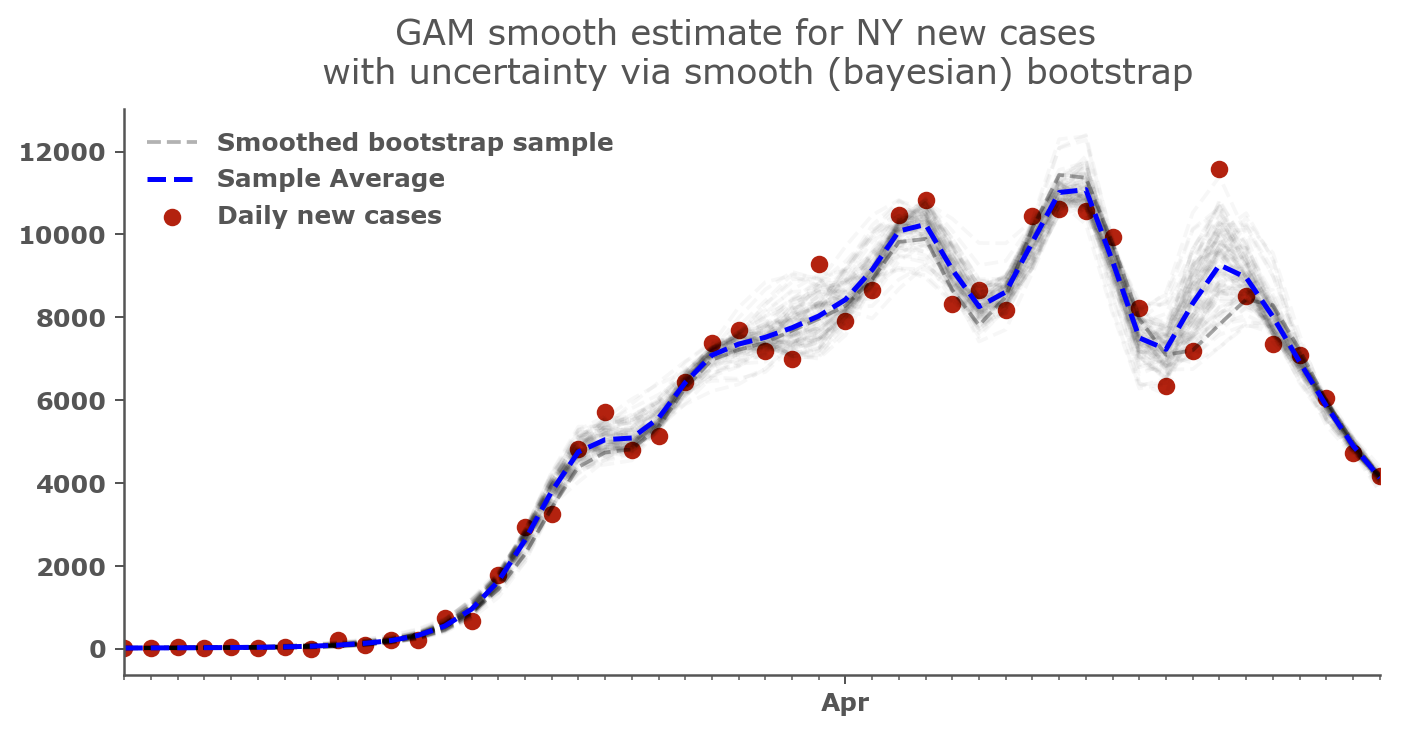

In [7]:
from scipy.stats import dirichlet

# fitting GAM
X = np.arange(series.shape[0])
y = series['confirmed_new'].values

# running GAM in bootstrap
bootstrap = []
for _ in range(100):

    weights = dirichlet([1] * series.shape[0]).rvs(1)

    gam = PoissonGAM(s(0, 25) + l(0))
    gam.fit(X, y, weights=weights[0])

    bootstrap.append(gam)

preds = pd.DataFrame([m.predict(X) for m in bootstrap]).T

# opening figure
fig, ax = plt.subplots(figsize=(9, 4), dpi=90)

plt.scatter(series.index.get_level_values(1), series['confirmed_new'], label='Daily new cases')
plt.plot(series.index.get_level_values(1), preds, 'k--', alpha=0.03)

plt.plot(series.index.get_level_values(1), preds.loc[:,0], 'k--', alpha=0.3, label='Smoothed bootstrap sample')
plt.plot(series.index.get_level_values(1), preds.mean(axis=1), 'b--', alpha=1.0, label='Sample Average', linewidth=2)

fig.set_facecolor('w') 
ax.set_title(f'GAM smooth estimate for {STATE_NAME} new cases \n with uncertainty via smooth (bayesian) bootstrap')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.xlim(series.index.get_level_values(1).min(),
         series.index.get_level_values(1).max())
ax.legend();

We wrap the GAM part in the `estimate_gam` function and proceed to estimate GAMs for daily new cases, and daily total cases:

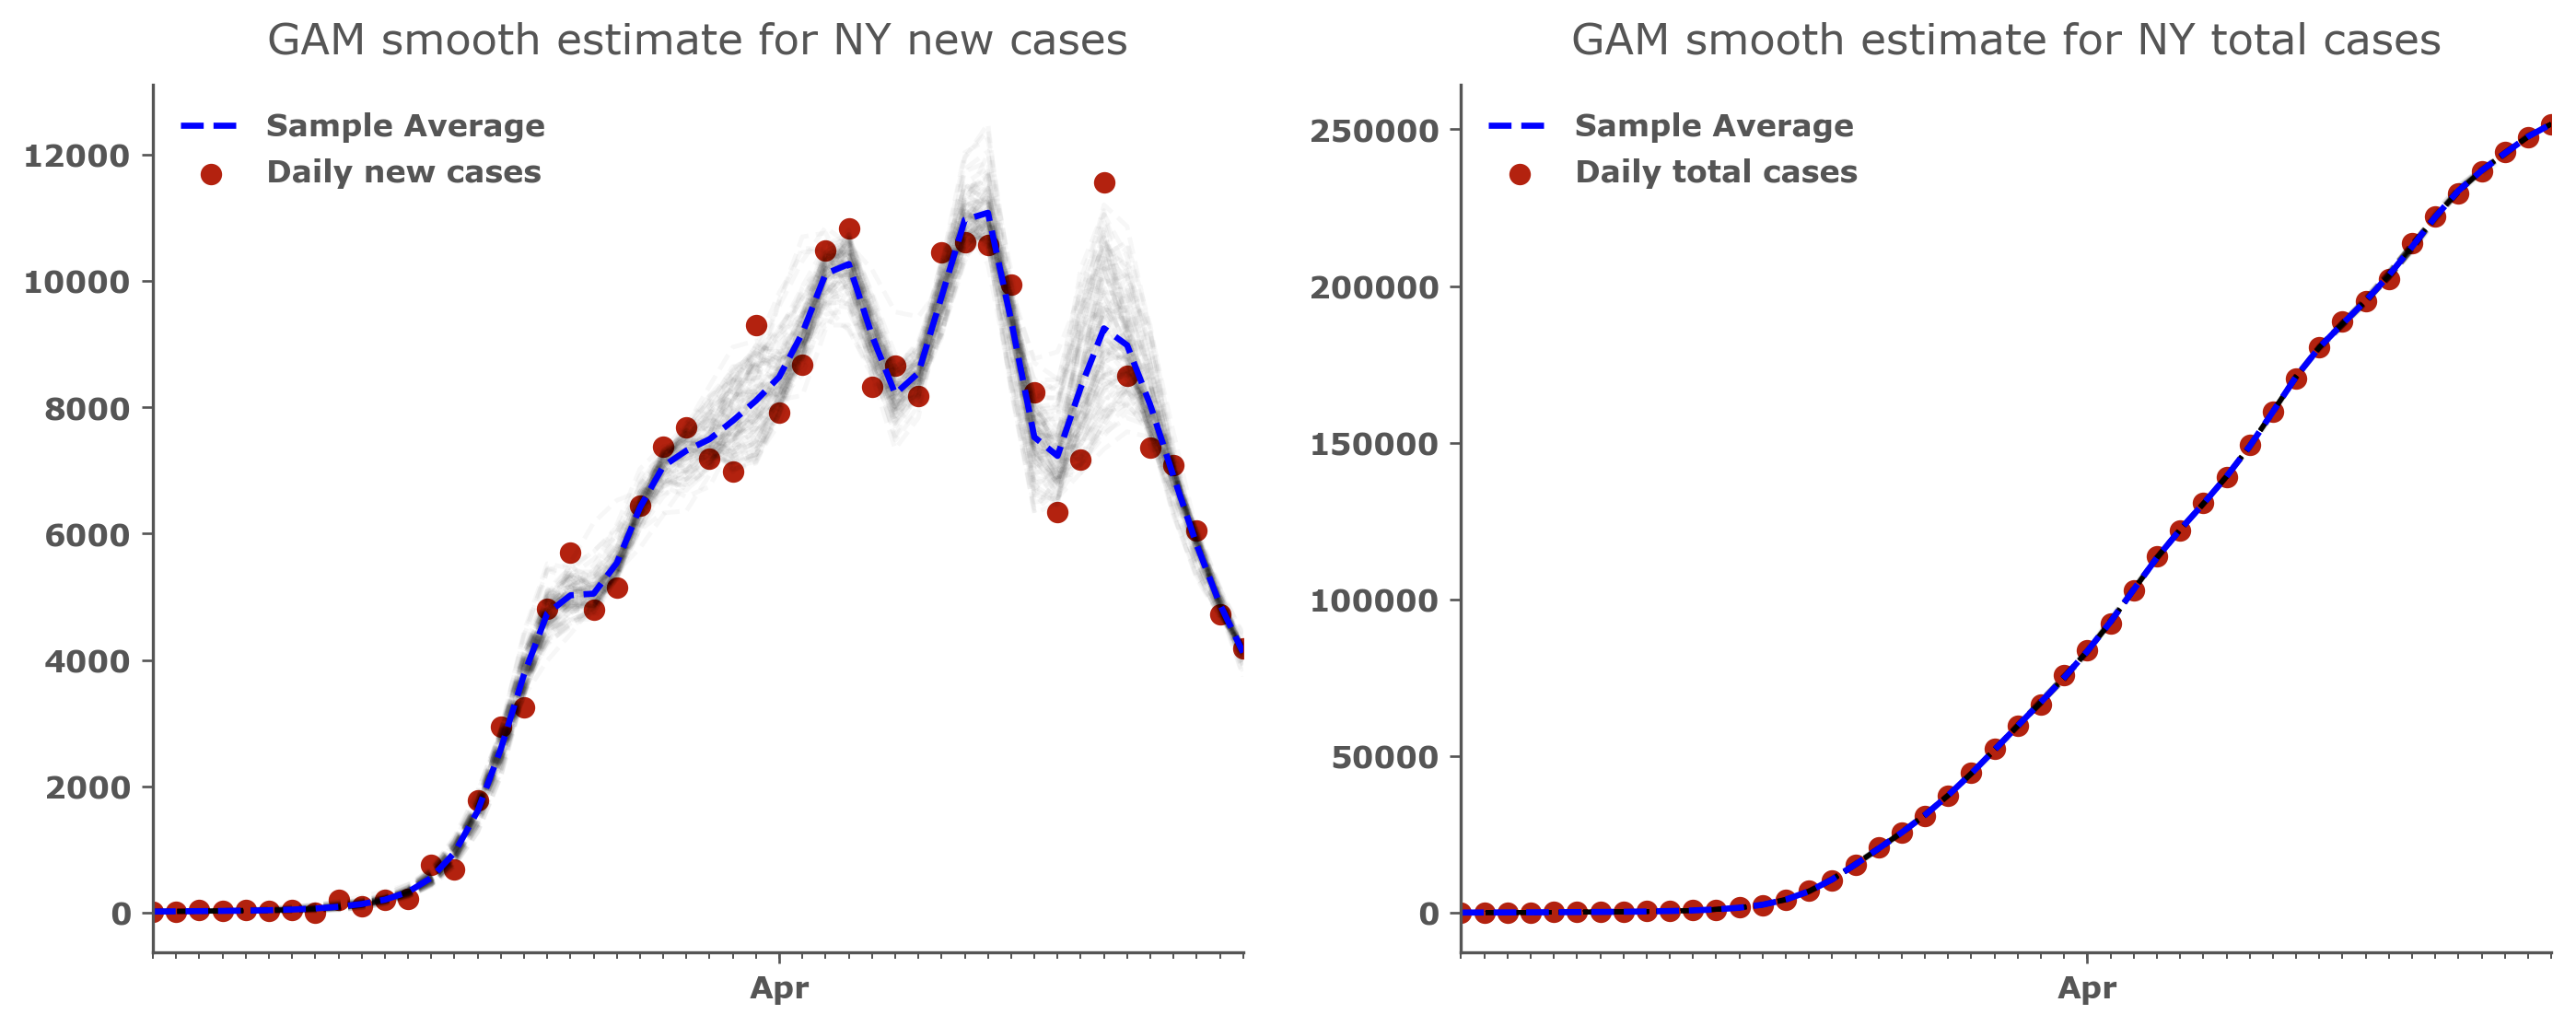

In [8]:
# running gams
preds_new = estimate_gam(series['confirmed_new'])
preds_total = estimate_gam(series['confirmed_total'])

# opening figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), dpi=120)

ax[0].scatter(series.index.get_level_values(1), series['confirmed_new'], label='Daily new cases')
ax[0].plot(series.index.get_level_values(1), preds_new, 'k--', alpha=0.03)
ax[0].plot(series.index.get_level_values(1), preds_new.mean(axis=1), 'b--', alpha=1.0, label='Sample Average', linewidth=2)
ax[0].set_xlim(series.index.get_level_values(1).min(),
         series.index.get_level_values(1).max())


ax[1].scatter(series.index.get_level_values(1), series['confirmed_total'], label='Daily total cases')
ax[1].plot(series.index.get_level_values(1), preds_total, 'k--', alpha=0.03)
ax[1].plot(series.index.get_level_values(1), preds_total.mean(axis=1), 'b--', alpha=1.0, label='Sample Average', linewidth=2)
ax[1].set_xlim(series.index.get_level_values(1).min(),
         series.index.get_level_values(1).max())


fig.set_facecolor('w') 
ax[0].set_title(f'GAM smooth estimate for {STATE_NAME} new cases')
ax[1].set_title(f'GAM smooth estimate for {STATE_NAME} total cases')

ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0].xaxis.set_minor_locator(mdates.DayLocator())
ax[0].legend();

ax[1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1].xaxis.set_minor_locator(mdates.DayLocator())
ax[1].legend();

Now that we have smoothness and uncertainty, we can go back to the $R_t$ estimate using the output of our GAMs, estimating $\beta_t$ by dividing the GAM estimating new cases by the GAM estimating total cases, shifted by 1 day.

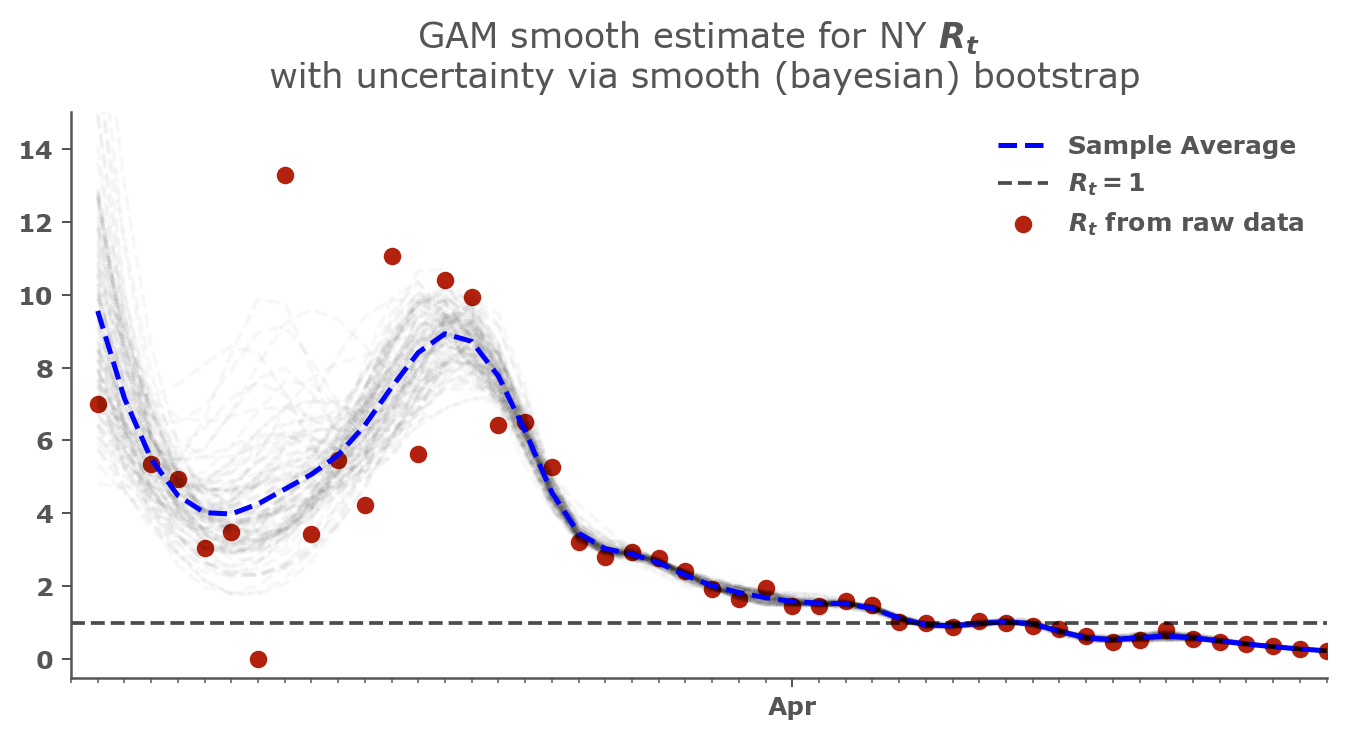

In [9]:
# SIR definition of R, with our GAMs as parameters
beta_t_gams = preds_new / preds_total.shift(1) 
Rt_gams = beta_t_gams * (1/RECOVERY_RATE)

# opening figure
fig, ax = plt.subplots(figsize=(9, 4), dpi=90)

plt.scatter(series.index.get_level_values(1), Rt_raw, label='$R_t$ from raw data')
plt.plot(series.index.get_level_values(1), Rt_gams, 'k--', alpha=0.03)
plt.plot(series.index.get_level_values(1), Rt_gams.mean(axis=1), 'b--', alpha=1.0, label='Sample Average', linewidth=2)
plt.plot(Rt_raw.index.get_level_values(1), [1] * Rt_raw.shape[0], 'k--', alpha=0.7, label='$R_t = 1$')

fig.set_facecolor('w') 
ax.set_title(f'GAM smooth estimate for {STATE_NAME} $R_t$ \n with uncertainty via smooth (bayesian) bootstrap')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.xlim(series.index.get_level_values(1).min(),
         series.index.get_level_values(1).max())
plt.ylim(-0.5, 15)
ax.legend();

### Running for all states

Let us run this model for all states. Everything is wrapped up in the `run_gam_effective_r_from_counts` function.

In [10]:
### running posteriors ###

with Parallel(n_jobs=N_JOBS) as parallel:
    results = parallel(delayed(run_gam_effective_r_from_counts)(grp[1]) for grp in state_df.groupby(level='state'))

final_results = pd.concat(results)

Using the same plot format as before:

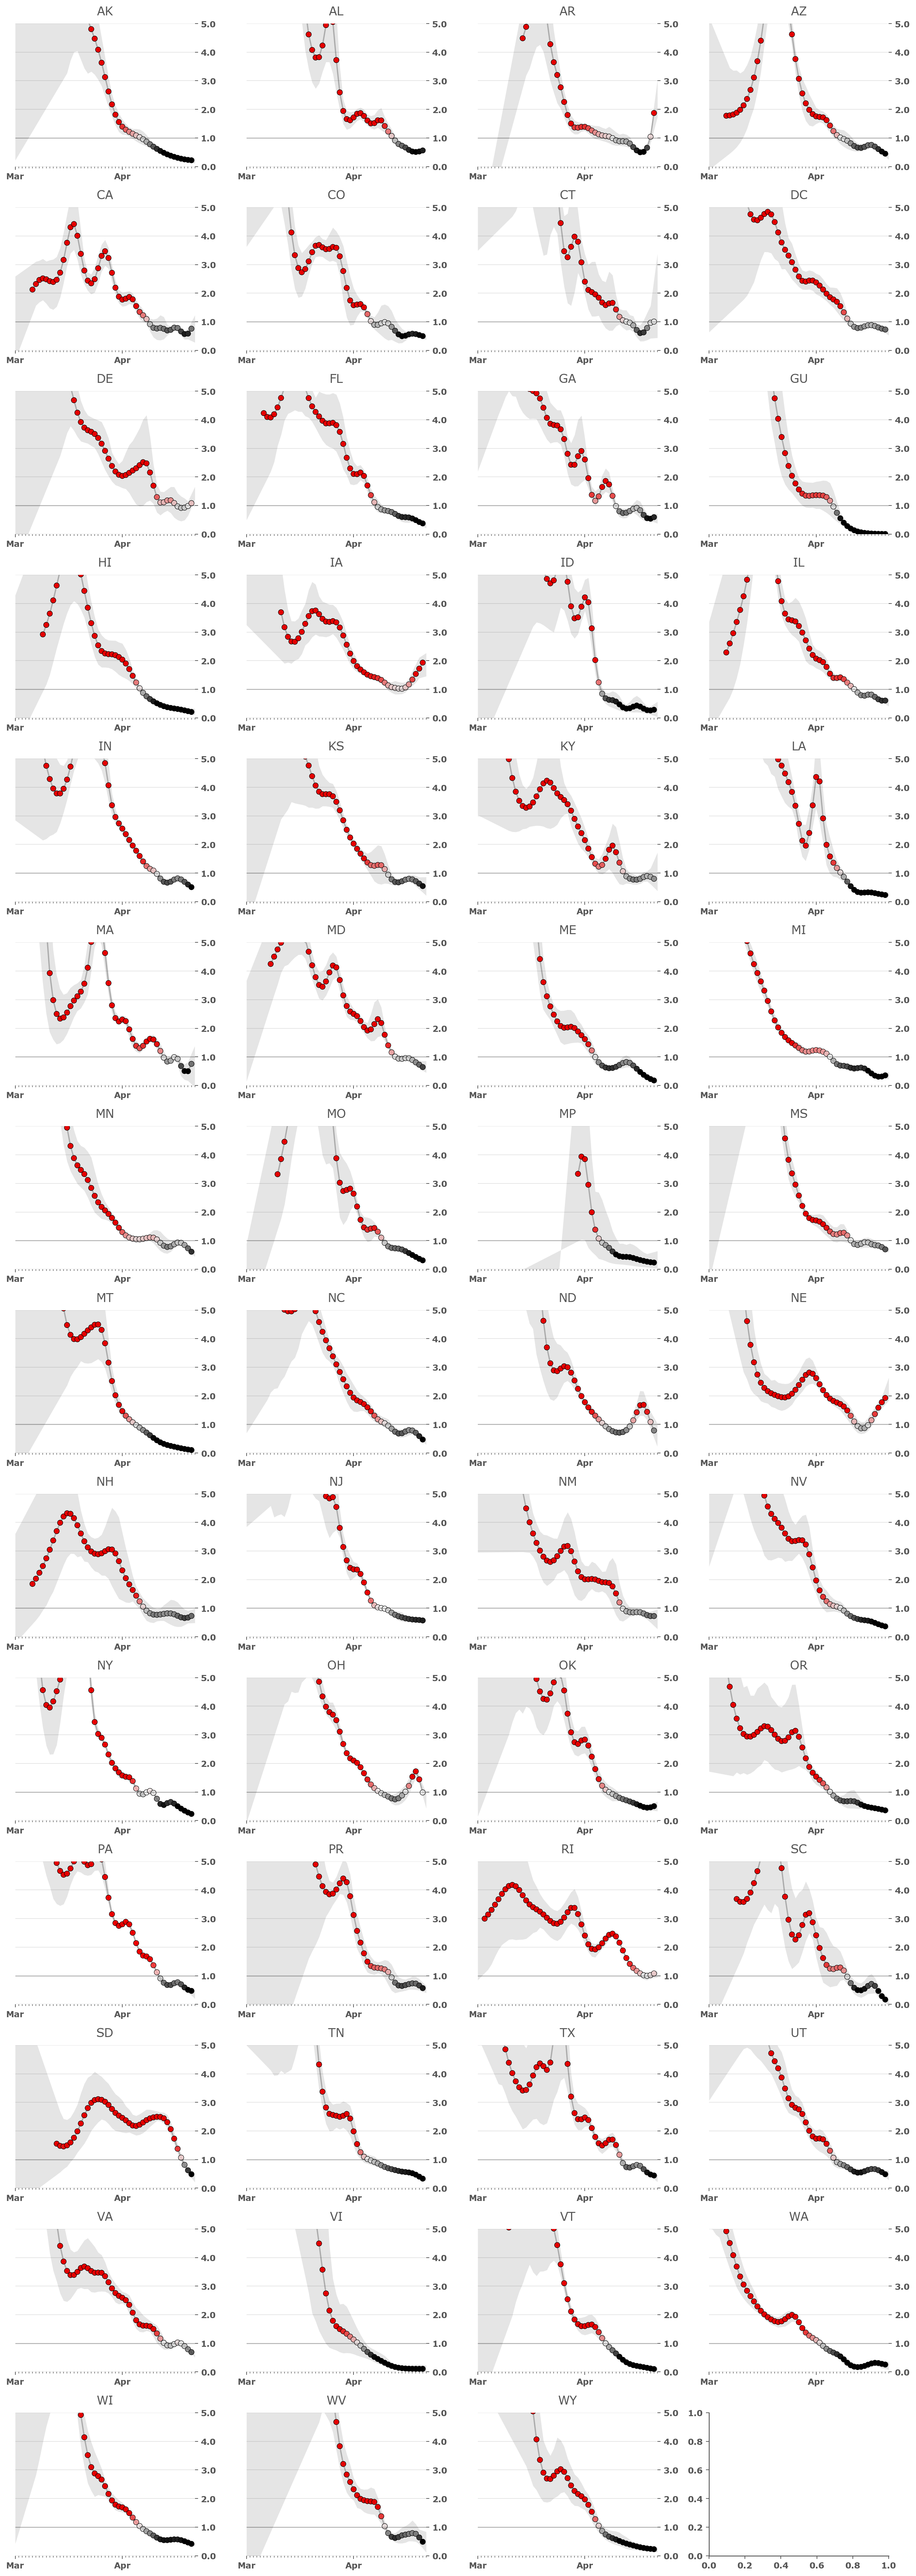

In [11]:
### plotting - Rt vs time for all states ###

def plot_rt_states():

    # number of columns and rows for plotting
    N_COLS = 4
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figure
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('state')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()

### Standings

Let us compare states.

Sorting by expected $R_t$:

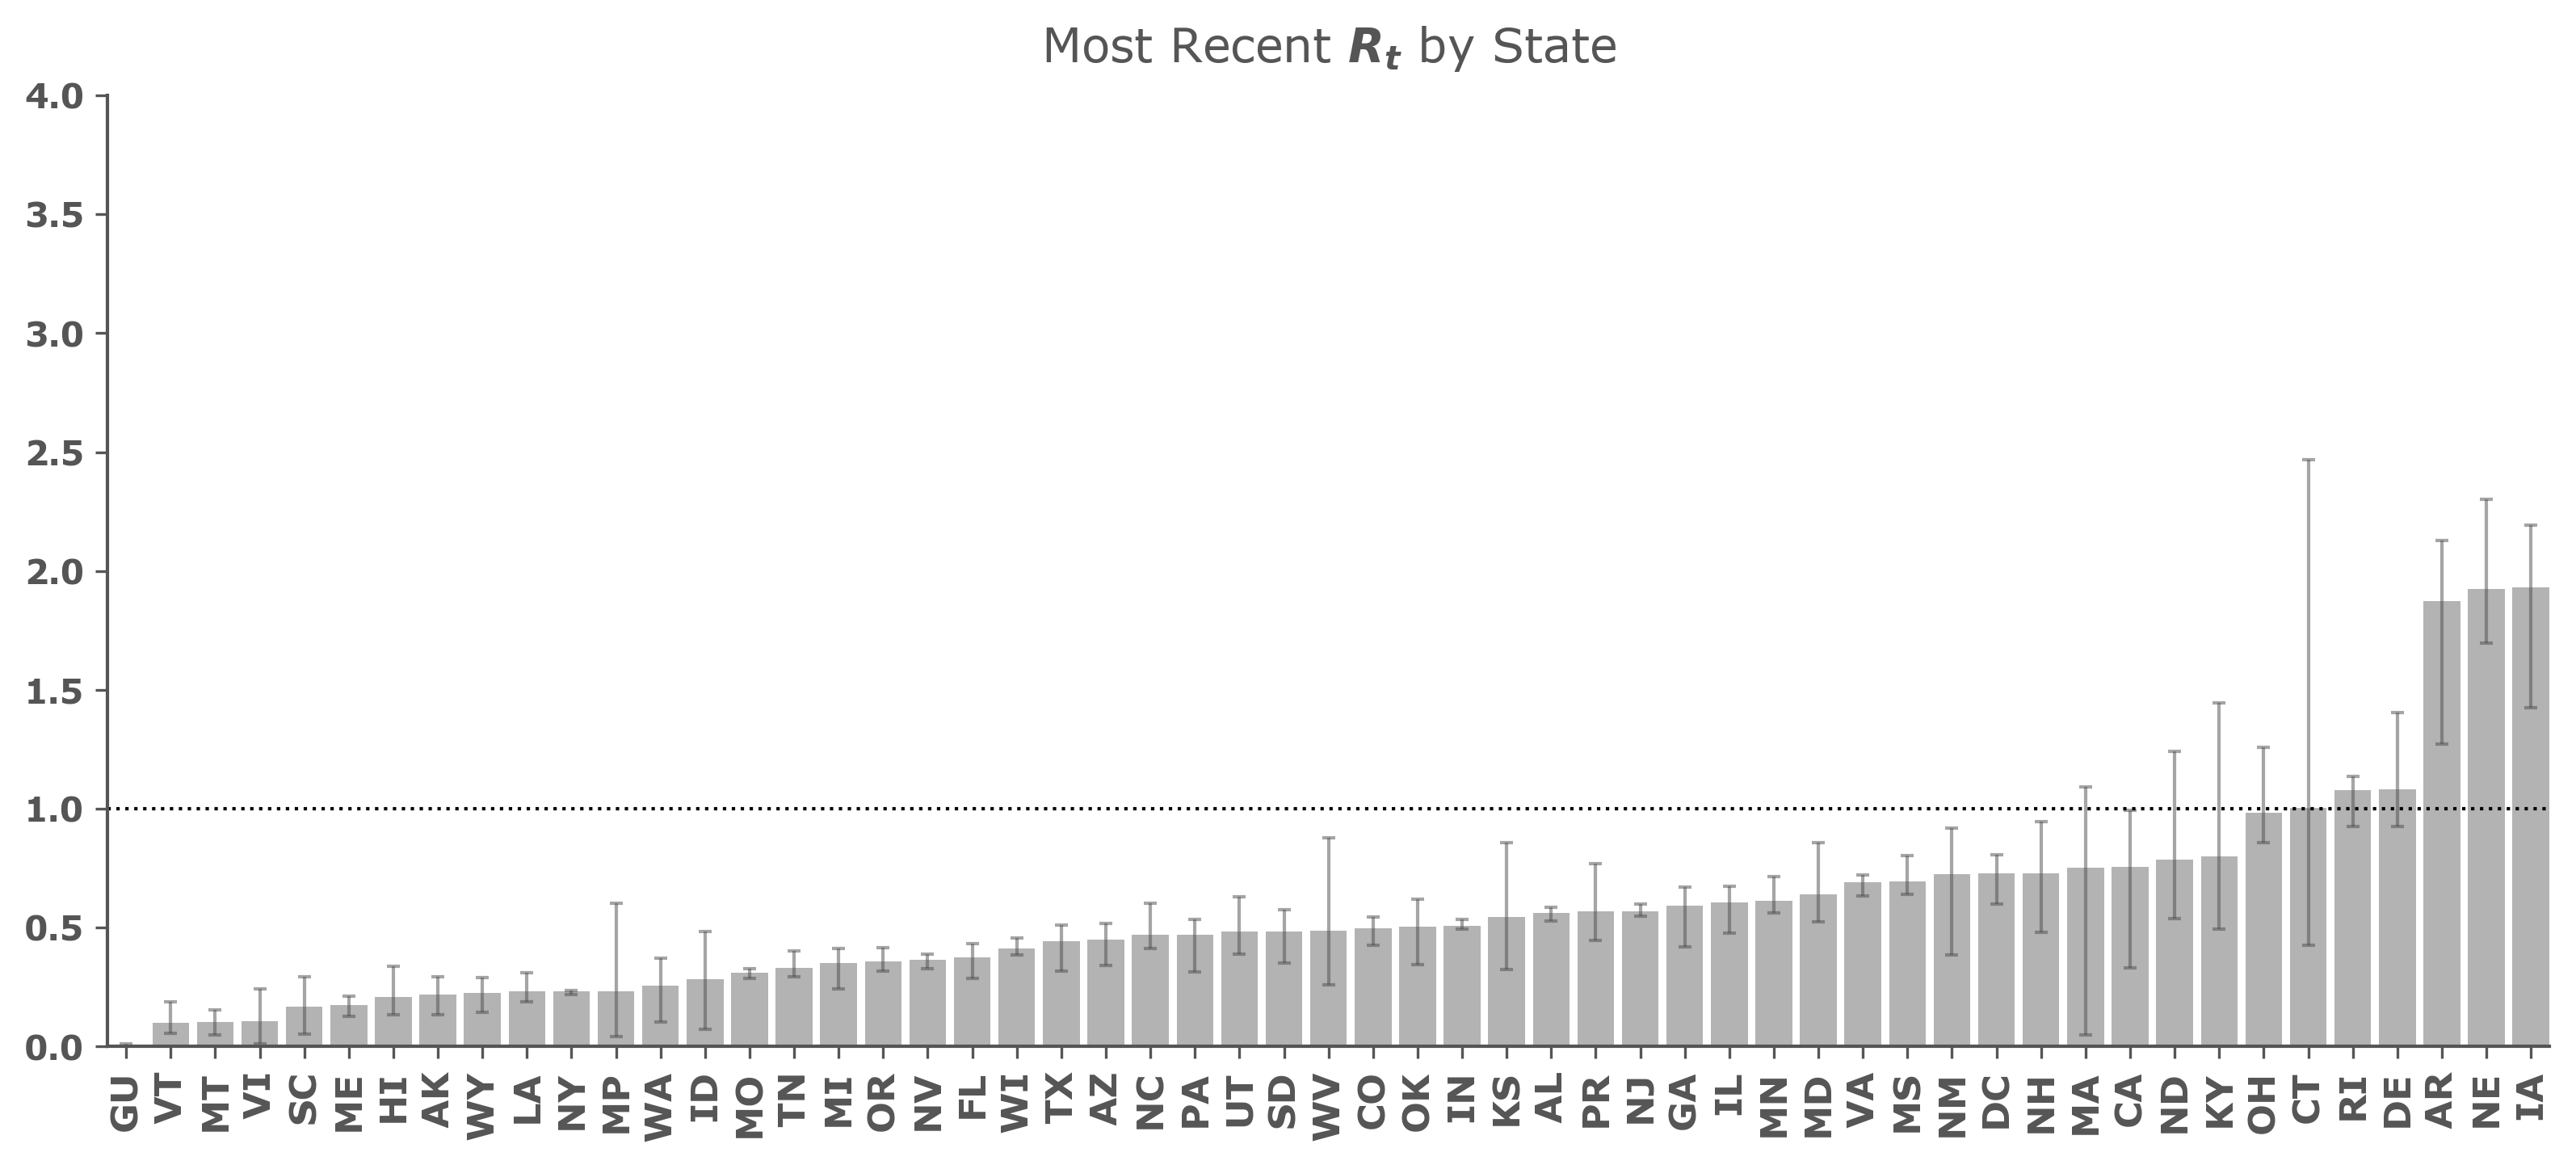

In [12]:
### plotting - state comparison ###

mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr.sort_values('ML', inplace=True)
plot_standings(mr, figsize=(13,5));

Sorting by worst case $R_t$:

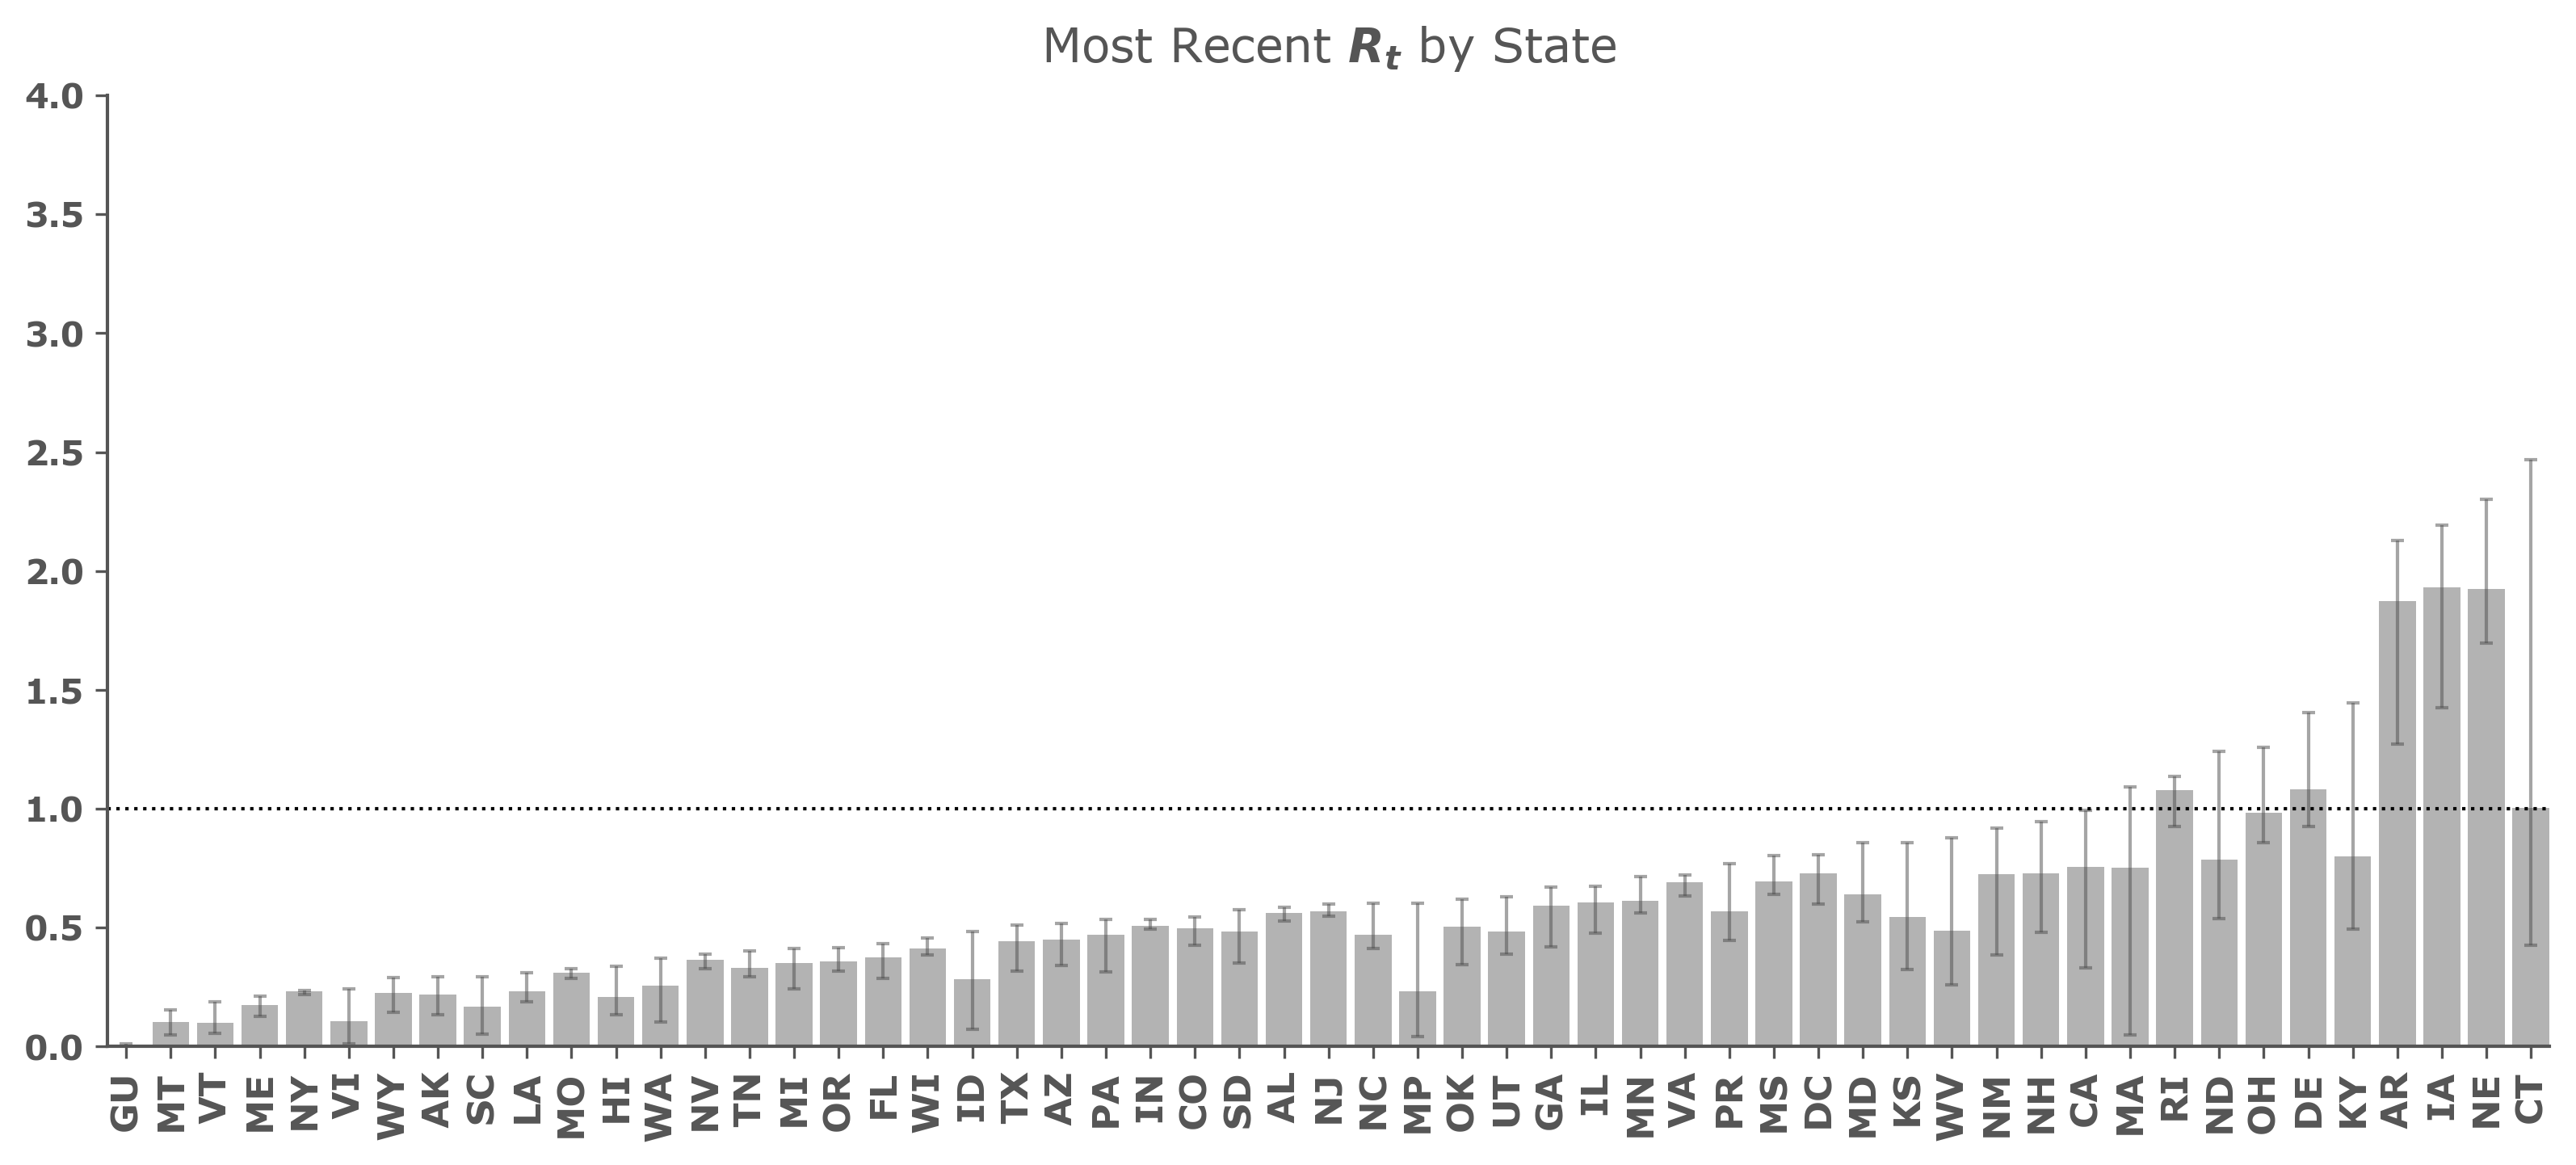

In [13]:
### ordering by worst case ##

mr.sort_values('High_90', inplace=True)
plot_standings(mr, figsize=(13,5));

### Comparing with Bettencourt & Ribeiro model

Let us compare models.

Text(0.5, 1.0, 'Real-time $R_t$ for NY, GAMs (Counts)')

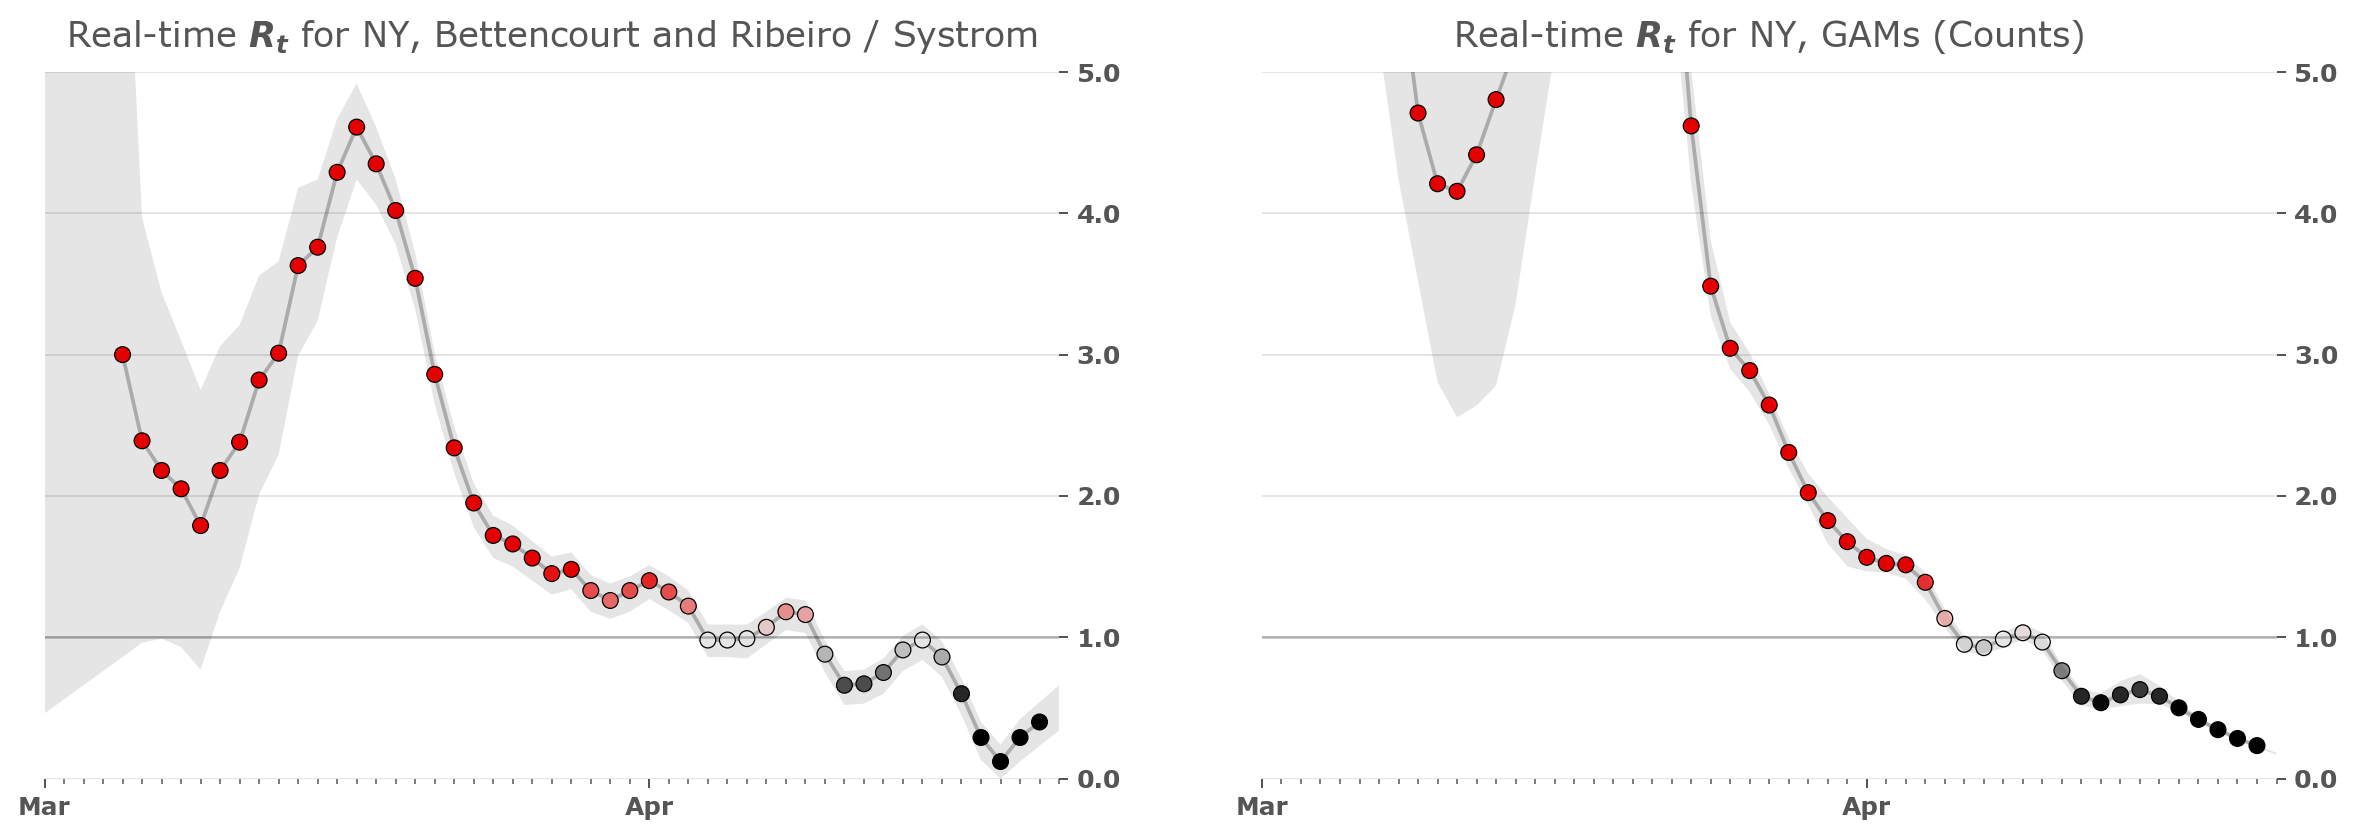

In [14]:
STATE_NAME = 'NY'

state_data = state_df.loc[lambda x: x.index.get_level_values(0) == STATE_NAME]

result_gam_counts = run_gam_effective_r_from_counts(state_data)
result_ribeiro = run_full_model(state_data['confirmed_new'], 0.25)

# opening figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5), dpi=90)

plot_rt(result_ribeiro, axes.flat[0], STATE_NAME)
plot_rt(result_gam_counts, axes.flat[1], STATE_NAME)

fig.set_facecolor('w') 
axes.flat[0].set_title(f'Real-time $R_t$ for {STATE_NAME}, Bettencourt and Ribeiro / Systrom')
axes.flat[1].set_title(f'Real-time $R_t$ for {STATE_NAME}, GAMs (Counts)')

The biggest issue with this implementation is that we did not put priors in the GAMs, and we see high variance on the initial days. I'll try to work on this.

## Wrapping up

Wrapping up our GAM model experiment, I can see some advantages and disavantages:

**ADVANTAGES**

* Expressive model to perform smoothing, which uses non-Gaussian error distributions (such as Poisson)
* Non-parametric uncertainty estimates using bootstrap
* Less moving parts 
* Framework of $\large R_t = \frac{\beta_t}{\gamma}$ works with other time series models. The focus is getting a good fit on the new cases and total cases time series, independent of the model.

**DISAVANTAGES**

* No prior, yet
* Uses SIR definition for $R_t$, may not be as good as the one using serial interval